In [4]:
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn

class OwlWrapper(nn.Module):

    def __init__(self, owl_vit):
        super().__init__()
        self.owl_vit = owl_vit.eval()

    def forward(self, logits, 

In [66]:
processor.image_processor

OwlViTImageProcessor {
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "OwlViTFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "OwlViTImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "OwlViTProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

In [71]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("../data/videos/pickleball_video/images/frame_00001.png")
texts = [["a photo of a tennis net", "a photo of a person", "an american flag"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


Detected a photo of a person with confidence 0.137 at location [58.24, 19.07, 73.7, 65.08]
Detected a photo of a person with confidence 0.146 at location [482.88, 2.6, 499.58, 36.41]
Detected a photo of a person with confidence 0.196 at location [515.74, 14.81, 531.37, 62.67]
Detected a photo of a person with confidence 0.137 at location [254.82, 80.54, 269.25, 101.46]
Detected a photo of a person with confidence 0.235 at location [383.38, 59.67, 400.05, 96.26]
Detected a photo of a person with confidence 0.184 at location [433.39, 72.51, 452.37, 100.03]
Detected a photo of a tennis net with confidence 0.19 at location [159.67, 237.54, 310.8, 282.01]
Detected a photo of a tennis net with confidence 0.16 at location [27.56, 221.35, 616.07, 286.86]
Detected a photo of a tennis net with confidence 0.104 at location [329.35, 249.24, 582.16, 282.68]
Detected a photo of a tennis net with confidence 0.19 at location [378.08, 225.58, 610.49, 285.67]
Detected a photo of a tennis net with confid

/usr/local/lib/python3.8/dist-packages/transformers/models/owlvit/image_processing_owlvit.py:355: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


In [72]:
import time
t0 = time.perf_counter_ns()
for i in range(10):
    outputs = model(**inputs)

torch.cuda.current_stream().synchronize()
t1 = time.perf_counter_ns()

print(10 / ((t1 - t0)/1e9))

1.7286666830694086


In [46]:
inputs['pixel_values'].shape

torch.Size([1, 3, 768, 768])

In [40]:
import time

In [73]:
valid_boxes = boxes[scores>0.25]

In [74]:
valid_boxes

tensor([[170.0214, 358.8204, 229.2874, 469.2054],
        [325.6402, 352.0051, 412.8905, 480.1952],
        [ 18.1396, 445.6665, 611.5800, 534.0477],
        [130.0369, 441.2256, 255.6121, 625.9431],
        [349.5661, 459.6440, 464.5201, 625.1917]], grad_fn=<IndexBackward0>)

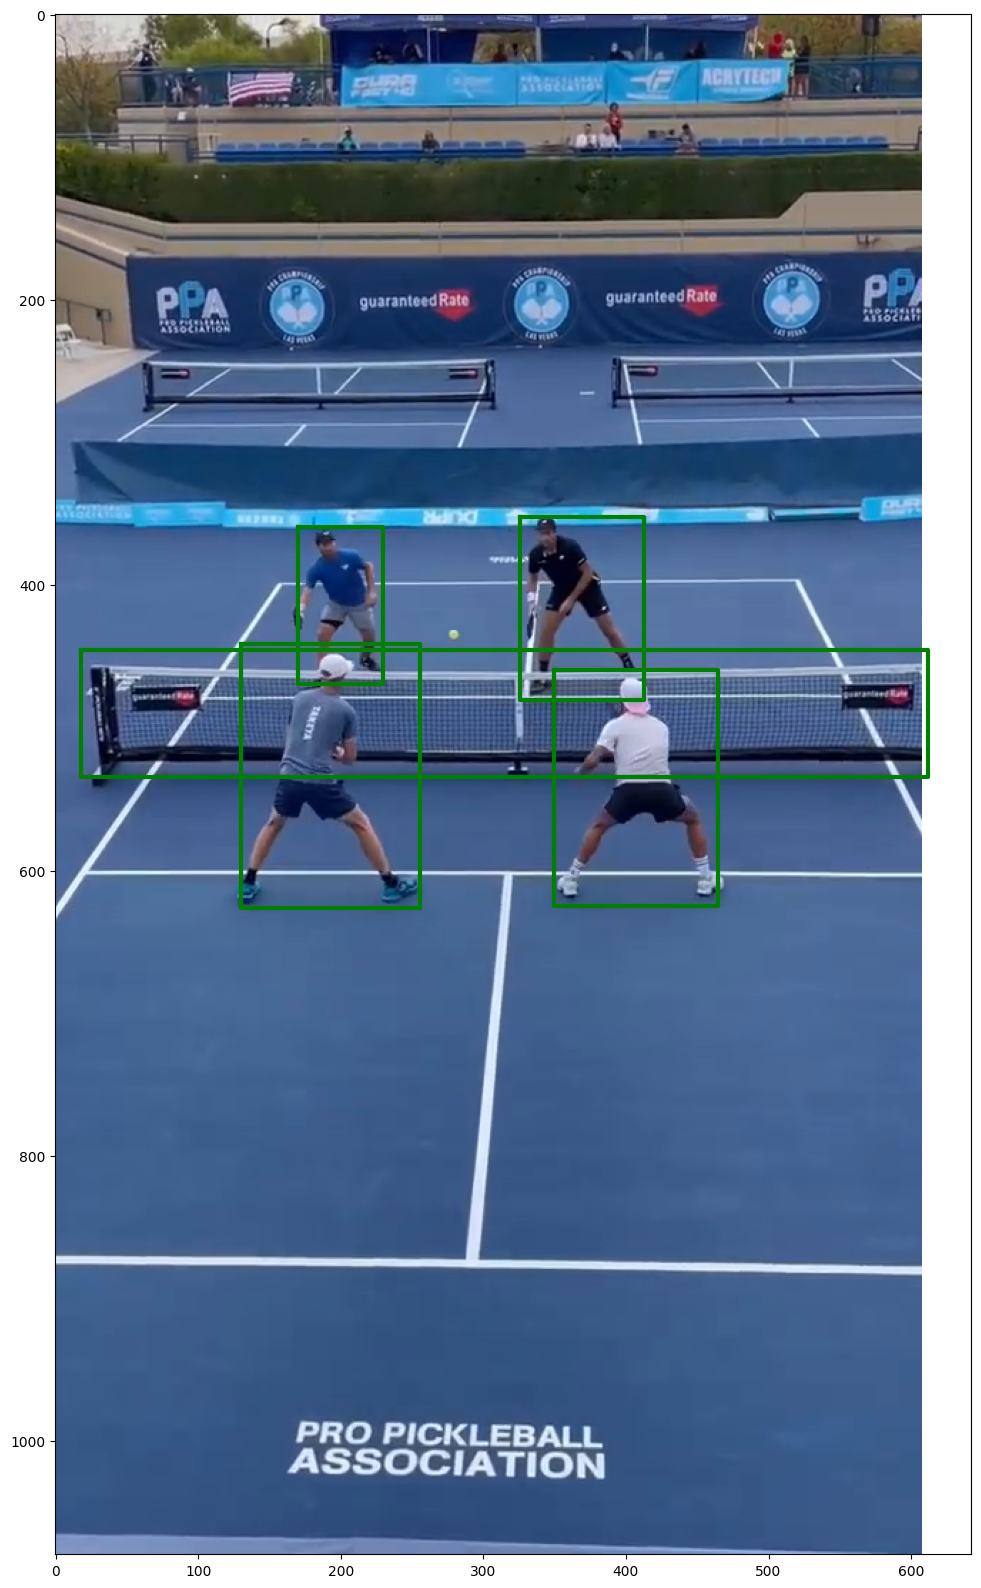

In [82]:
def plot_box(box):
    box = box.detach().cpu().numpy()
    x = [box[0], box[2], box[2], box[0], box[0]]
    y = [box[1], box[1], box[3], box[3], box[1]]
    plt.plot(x, y, 'g-', linewidth=3)


plt.figure(figsize=(20,20))
plt.imshow(image)
for box in valid_boxes:
    plot_box(box)
plt.show()

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from mobile_sam.predictor_trt import PredictorTRT

In [97]:
predictor_mobilesam = PredictorTRT(
    image_encoder_engine="../data/mobile_sam_image_encoder.engine",
    mask_decoder_engine="../data/mobile_sam_mask_decoder.engine",
    image_encoder_size=1024
)

In [98]:
predictor_nanosam = PredictorTRT(
    image_encoder_engine="../data/resnet18_huber_1024_v5.engine",
    mask_decoder_engine="../data/mobile_sam_mask_decoder.engine",
    image_encoder_size=1024
)

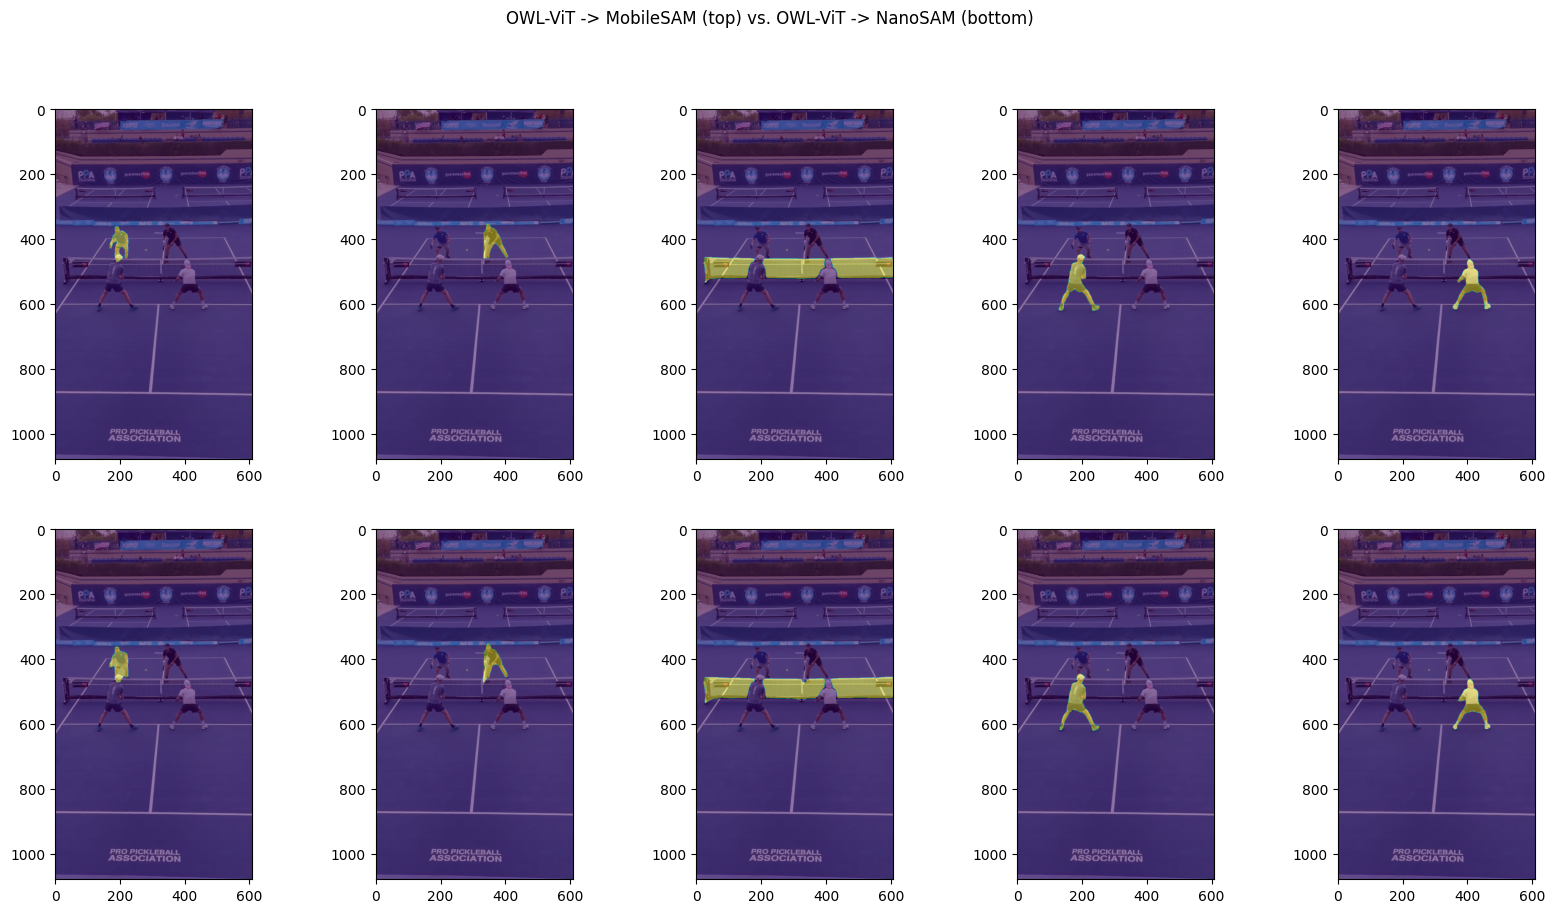

In [103]:
fig = plt.figure(figsize=(20, 10))
predictor_mobilesam.set_image(image)
for i, box in enumerate(valid_boxes):
    box = box.detach().cpu().numpy()
    points = np.array([
        [box[0], box[1]],
        [box[2], box[3]]
    ])
    point_labels = np.array([2, 3])

    mask, iou_preds, low_res_mask = predictor_mobilesam.predict(
        points=points,
        point_labels=point_labels
    )
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.imshow(mask[0, iou_preds.argmax()].detach().cpu() > 0, alpha=0.5)

predictor_nanosam.set_image(image)
for i, box in enumerate(valid_boxes):
    box = box.detach().cpu().numpy()
    points = np.array([
        [box[0], box[1]],
        [box[2], box[3]]
    ])
    point_labels = np.array([2, 3])

    mask, iou_preds, low_res_mask = predictor_nanosam.predict(
        points=points,
        point_labels=point_labels
    )
    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(image)
    plt.imshow(mask[0, iou_preds.argmax()].detach().cpu() > 0, alpha=0.5)

plt.suptitle("OWL-ViT -> MobileSAM (top) vs. OWL-ViT -> NanoSAM (bottom)")
fig.savefig("output_mobilesam_vs_nanosam.png")

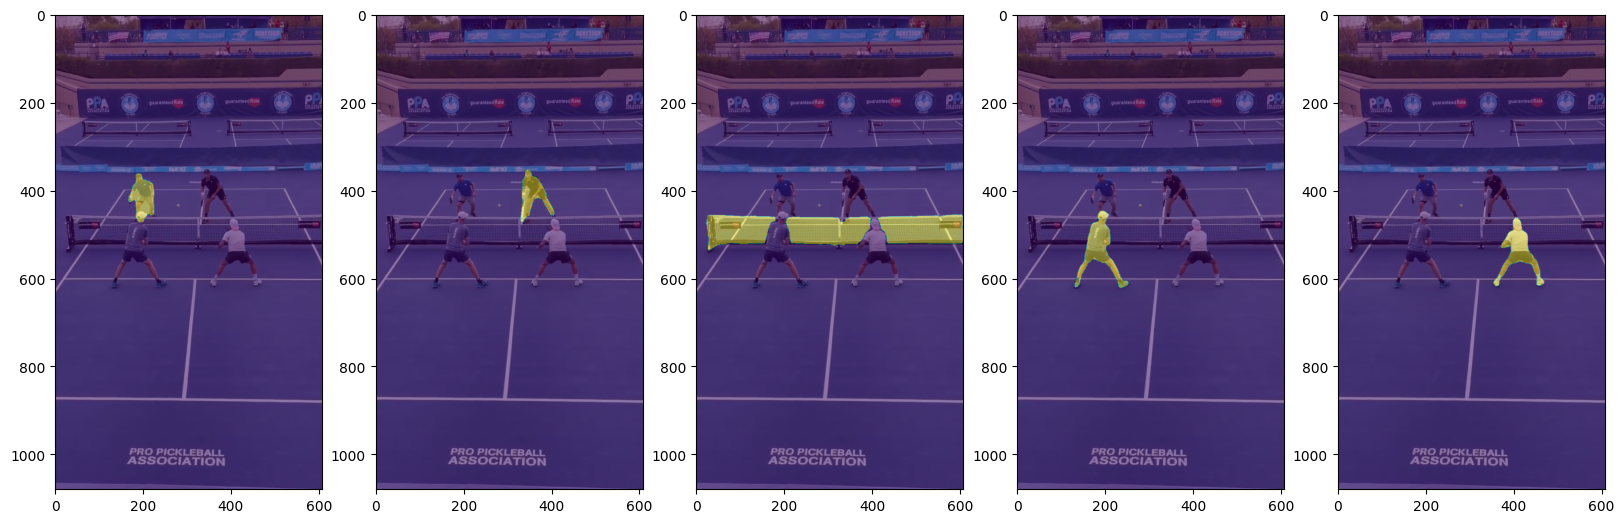

In [93]:
fig = plt.figure(figsize=(20, 20))
predictor.set_image(image)
for i, box in enumerate(valid_boxes):
    box = box.detach().cpu().numpy()
    points = np.array([
        [box[0], box[1]],
        [box[2], box[3]]
    ])
    point_labels = np.array([2, 3])

    mask, iou_preds, low_res_mask = predictor.predict(
        points=points,
        point_labels=point_labels
    )
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.imshow(mask[0, iou_preds.argmax()].detach().cpu() > 0, alpha=0.5)

fig.savefig("output_nanosam.png")